# Day 19: Beacon scanner

In [1]:
from icecream import ic

from vectors import Vector2, Vector3

As your probe drifted down through this area, it released an assortment of beacons and scanners into the water. It's difficult to navigate in the pitch black open waters of the ocean trench, but if you can build a map of the trench using data from the scanners, you should be able to safely reach the bottom.

The beacons and scanners float motionless in the water; they're designed to maintain the same position for long periods of time. Each scanner is capable of detecting all beacons in a large cube centered on the scanner; beacons that are at most 1000 units away from the scanner in each of the three axes (`x`, `y`, and `z`) have their precise position determined relative to the scanner. However, scanners cannot detect other scanners. The submarine has automatically summarized the relative positions of beacons detected by each scanner (your puzzle input).

For example, if a scanner is at `x`, `y`, `z` coordinates $500,0,-500$ and there are beacons at $-500,1000,-1500$ and $1501,0,-500$, the scanner could report that the first beacon is at $-1000,1000,-1000$ (relative to the scanner) but would not detect the second beacon at all.

Unfortunately, while each scanner can report the positions of all detected beacons relative to itself, **the scanners do not know their own position**. You'll need to determine the positions of the beacons and scanners yourself.

The scanners and beacons map a single contiguous 3d region. This region can be reconstructed by finding pairs of scanners that have overlapping detection regions such that there are **at least 12 beacons** that both scanners detect within the overlap. By establishing 12 common beacons, you can precisely determine where the scanners are relative to each other, allowing you to reconstruct the beacon map one scanner at a time.

For a moment, consider only two dimensions. Suppose you have the following scanner reports:

```
--- scanner 0 ---
0,2
4,1
3,3

--- scanner 1 ---
-1,-1
-5,0
-2,1
```

In [2]:
## Reading the scanner reports

import re



def load_lines(filename):
     with open(filename) as f_input:
        buff = []
        for line in f_input:
            line = line.strip()
            if line == '' and buff:
                yield buff
                buff = []
            else:
                buff.append(line)
        if buff:
            yield buff
            
assert list(load_lines('19-sample-2d.txt')) == [
    [
        '--- scanner 0 ---',
        '0,2',
        '4,1',
        '3,3',
    ], [
        '--- scanner 1 ---',
        '-1,-1',
        '-5,0',
        '-2,1',
    ]
]

In [3]:
class Scanner2D:
    def __init__(self, name):
        self.name = name
        self.beacons = []
        
    def add_beacon(self, x, y):
        self.beacons.append(Vector2(x, y))
        
    def __str__(self):
        buff = [f'--- {self.name} ---']
        for beacon in self.beacons:
            buff.append(f"{beacon.x}, {beacon.y}")
        return "\n".join(buff)

pat_scanner = re.compile("--- scanner (\d+) ---")
pat_point_2d = re.compile("(-?\d+),(-?\d+)")


def load_input_2d(filename) -> [Scanner2D]:
    for lines in load_lines(filename):
        header, *body = lines
        m = pat_scanner.match(header)
        num = int(m.group(1))
        scanner = Scanner2D(f'scanner {num:02}')
        for line in body:
            m = pat_point_2d.match(line)
            x = int(m.group(1))
            y = int(m.group(2))
            scanner.add_beacon(x, y)
        yield scanner

In [4]:
a, b = load_input_2d('19-sample-2d.txt')

assert a.name == 'scanner 00'
assert len(a.beacons) == 3
assert a.beacons[0] == Vector2(0, 2)
assert a.beacons[1] == Vector2(4, 1)
assert a.beacons[2] == Vector2(3, 3)

assert b.name == 'scanner 01'
assert len(b.beacons) == 3
assert b.beacons[0] == Vector2(-1, -1)
assert b.beacons[1] == Vector2(-5, 0)
assert b.beacons[2] == Vector2(-2, 1)


In [5]:
print(a, b, sep="\n")

--- scanner 00 ---
0, 2
4, 1
3, 3
--- scanner 01 ---
-1, -1
-5, 0
-2, 1


Drawing x increasing rightward, y increasing upward, scanners as `S`, and beacons as `B`, scanner 0 detects this:

```
...B.
B....
....B
S....
```

Scanner 1 detects this:

```
...B..
B....S
....B.
```

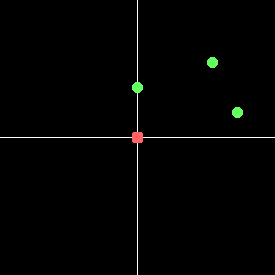

In [6]:
import show

def show_scanner(scanner: Scanner2D, size=11):
    grid = show.Grid(11, 11)
    grid.box(Vector2(0, 0))
    for beacon in scanner.beacons:
        grid.dot(beacon)
    return grid

a, b = load_input_2d('19-sample-2d.txt')
show_scanner(a).img

In [7]:
import itertools

def match_scanners(s1: Scanner2D, s2: Scanner2D, tope):
    for p1, p2 in itertools.product(s1.beacons, s2.beacons):
        delta = p2 - p1
        traslated_set = set([_ + delta for _ in s1.beacons])
        num_matches = len(traslated_set.intersection(s2.beacons))
        if num_matches >= tope:
            return delta
    return None
    
ic(match_scanners(a, b, 3))

ic| match_scanners(a, b, 3): Vector2(x=-5, y=-2)


Vector2(x=-5, y=-2)

In [8]:
a, b = load_input_2d('19-sample-2d.txt')
offset = match_scanners(a, b, 3)
for p in [offset + v for v in a.beacons]:
    print(p,p in b.beacons)

(-5, 0) True
(-1, -1) True
(-2, 1) True


For this example, assume scanners only need 3 overlapping beacons. Then, the beacons visible to both scanners overlap to produce the following complete map:

```
...B..
B....S
....B.
S.....
```

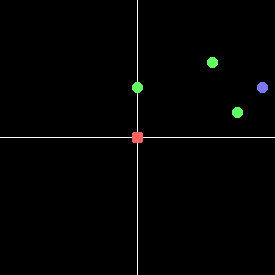

In [9]:
a, b = load_input_2d('19-sample-2d.txt')
offset = match_scanners(a, b, 3)
grid = show_scanner(a)
grid.dot(-offset, color=(120, 120, 240, 255))
grid.img

Unfortunately, there's a second problem: the scanners also don't know their **rotation or facing direction**. Due to magnetic alignment, each scanner is rotated some integer number of 90-degree turns around all of the x, y, and z axes. That is, one scanner might call a direction positive x, while another scanner might call that direction negative y. Or, two scanners might agree on which direction is positive x, but one scanner might be upside-down from the perspective of the other scanner. In total, each scanner could be in any of 24 different orientations: facing positive or negative x, y, or z, and considering any of four directions "up" from that facing.

In [10]:
class Scanner3D:
    def __init__(self, name):
        self.name = name
        self.beacons = []
        
    def add_beacon(self, x, y, z):
        self.beacons.append(Vector3(x, y, z))
        
    def __str__(self):
        buff = [f'--- {self.name} ---']
        for beacon in self.beacons:
            buff.append(f"{beacon.x}, {beacon.y}, {beacon.z}")
        return "\n".join(buff)

pat_scanner = re.compile("--- scanner (\d+) ---")
pat_point_3d = re.compile("(-?\d+),(-?\d+),(-?\d+)")
    
    
def load_input_3d(filename) -> [Scanner3D]:
    for lines in load_lines(filename):
        header, *body = lines
        m = pat_scanner.match(header)
        num = int(m.group(1))
        scanner = Scanner3D(f'scanner {num:02}')
        for line in body:
            m = pat_point_3d.match(line)
            x = int(m.group(1))
            y = int(m.group(2))
            z = int(m.group(3))
            scanner.add_beacon(x, y, z)
        yield scanner
        

For example, here is an arrangement of beacons as seen from a scanner in the same position but in different orientations:

```
--- scanner 0 ---
-1,-1,1
-2,-2,2
-3,-3,3
-2,-3,1
5,6,-4
8,0,7

--- scanner 0 ---
1,-1,1
2,-2,2
3,-3,3
2,-1,3
-5,4,-6
-8,-7,0

--- scanner 0 ---
-1,-1,-1
-2,-2,-2
-3,-3,-3
-1,-3,-2
4,6,5
-7,0,8

--- scanner 0 ---
1,1,-1
2,2,-2
3,3,-3
1,3,-2
-4,-6,5
7,0,8

--- scanner 0 ---
1,1,1
2,2,2
3,3,3
3,1,2
-6,-4,-5
0,7,-8
```

In [11]:
for scanner in load_input_3d('sample-rotated.txt'):
    print(scanner)

--- scanner 00 ---
-1, -1, 1
-2, -2, 2
-3, -3, 3
-2, -3, 1
5, 6, -4
8, 0, 7
--- scanner 00 ---
1, -1, 1
2, -2, 2
3, -3, 3
2, -1, 3
-5, 4, -6
-8, -7, 0
--- scanner 00 ---
-1, -1, -1
-2, -2, -2
-3, -3, -3
-1, -3, -2
4, 6, 5
-7, 0, 8
--- scanner 00 ---
1, 1, -1
2, 2, -2
3, 3, -3
1, 3, -2
-4, -6, 5
7, 0, 8
--- scanner 00 ---
1, 1, 1
2, 2, 2
3, 3, 3
3, 1, 2
-6, -4, -5
0, 7, -8


In [75]:
def transformations():
    return [   
        lambda p: Vector3(p.x, p.y, p.z), # Y is UP (No change)
        lambda p: Vector3(-p.z, p.y, p.x),
        lambda p: Vector3(p.z, p.y, -p.x),
        lambda p: Vector3(-p.x, p.y, -p.z),
        lambda p: Vector3(-p.x, -p.y, p.z), # -Y is UP
        lambda p: Vector3(-p.z, -p.y, -p.x),
        lambda p: Vector3(p.z, -p.y, p.x),
        lambda p: Vector3(p.x, -p.y, -p.z),
        lambda p: Vector3(-p.y, p.x, p.z),  # X is UP
        lambda p: Vector3(-p.z, p.x, -p.y),
        lambda p: Vector3(p.z, p.x, p.y),
        lambda p: Vector3(p.y, p.x, -p.z),
        lambda p: Vector3(p.y, -p.x, p.z),  # -X is UP
        lambda p: Vector3(-p.z, -p.x, p.y),
        lambda p: Vector3(p.z, -p.x, -p.y),
        lambda p: Vector3(-p.y, -p.x, -p.z),
        lambda p: Vector3(p.x, p.z, -p.y),  # Z is UP
        lambda p: Vector3(p.y, p.z, p.x),
        lambda p: Vector3(-p.y, p.z, -p.x),
        lambda p: Vector3(-p.x, p.z , p.y),
        lambda p: Vector3(p.x, -p.z, p.y),  # Z is UP
        lambda p: Vector3(-p.y, -p.z, p.x),
        lambda p: Vector3(p.y, -p.z, -p.x),
        lambda p: Vector3(-p.x, -p.z, -p.y),
    ]

In [77]:
def is_transformable(s1: scanner, s2:scanner) -> True:
    source = list(s1.beacons)
    for transform in transformations():
        if source == [transform(p) for p in s2.beacons]:
            return True

In [83]:
a, b, c, d, e = load_input_3d('sample-rotated.txt')
for s1, s2 in itertools.permutations([a, b, c, d, e], 2):
    assert is_transformable(s1, s2)

## POR AQUI

By finding pairs of scanners that both see at least 12 of the same beacons, you can assemble the entire map. For example, consider the following report:


```
--- scanner 0 ---
404,-588,-901
528,-643,409
-838,591,734
390,-675,-793
-537,-823,-458
-485,-357,347
-345,-311,381
-661,-816,-575
-876,649,763
-618,-824,-621
553,345,-567
474,580,667
-447,-329,318
-584,868,-557
544,-627,-890
564,392,-477
455,729,728
-892,524,684
-689,845,-530
423,-701,434
7,-33,-71
630,319,-379
443,580,662
-789,900,-551
459,-707,401

--- scanner 1 ---
686,422,578
605,423,415
515,917,-361
-336,658,858
95,138,22
-476,619,847
-340,-569,-846
567,-361,727
-460,603,-452
669,-402,600
729,430,532
-500,-761,534
-322,571,750
-466,-666,-811
-429,-592,574
-355,545,-477
703,-491,-529
-328,-685,520
413,935,-424
-391,539,-444
586,-435,557
-364,-763,-893
807,-499,-711
755,-354,-619
553,889,-390

--- scanner 2 ---
649,640,665
682,-795,504
-784,533,-524
-644,584,-595
-588,-843,648
-30,6,44
-674,560,763
500,723,-460
609,671,-379
-555,-800,653
-675,-892,-343
697,-426,-610
578,704,681
493,664,-388
-671,-858,530
-667,343,800
571,-461,-707
-138,-166,112
-889,563,-600
646,-828,498
640,759,510
-630,509,768
-681,-892,-333
673,-379,-804
-742,-814,-386
577,-820,562

--- scanner 3 ---
-589,542,597
605,-692,669
-500,565,-823
-660,373,557
-458,-679,-417
-488,449,543
-626,468,-788
338,-750,-386
528,-832,-391
562,-778,733
-938,-730,414
543,643,-506
-524,371,-870
407,773,750
-104,29,83
378,-903,-323
-778,-728,485
426,699,580
-438,-605,-362
-469,-447,-387
509,732,623
647,635,-688
-868,-804,481
614,-800,639
595,780,-596

--- scanner 4 ---
727,592,562
-293,-554,779
441,611,-461
-714,465,-776
-743,427,-804
-660,-479,-426
832,-632,460
927,-485,-438
408,393,-506
466,436,-512
110,16,151
-258,-428,682
-393,719,612
-211,-452,876
808,-476,-593
-575,615,604
-485,667,467
-680,325,-822
-627,-443,-432
872,-547,-609
833,512,582
807,604,487
839,-516,451
891,-625,532
-652,-548,-490
30,-46,-14
```

Because all coordinates are relative, in this example, all "absolute" positions will be expressed relative to scanner 0 (using the orientation of scanner 0 and as if scanner 0 is at coordinates 0,0,0).

Scanners 0 and 1 have overlapping detection cubes; the 12 beacons they both detect (relative to scanner 0) are at the following coordinates:

```
-618,-824,-621
-537,-823,-458
-447,-329,318
404,-588,-901
544,-627,-890
528,-643,409
-661,-816,-575
390,-675,-793
423,-701,434
-345,-311,381
459,-707,401
-485,-357,347
```

These same 12 beacons (in the same order) but from the perspective of scanner 1 are:

```
686,422,578
605,423,415
515,917,-361
-336,658,858
-476,619,847
-460,603,-452
729,430,532
-322,571,750
-355,545,-477
413,935,-424
-391,539,-444
553,889,-390
```

Because of this, scanner 1 must be at 68,-1246,-43 (relative to scanner 0).

Scanner 4 overlaps with scanner 1; the 12 beacons they both detect (relative to scanner 0) are:

```
459,-707,401
-739,-1745,668
-485,-357,347
432,-2009,850
528,-643,409
423,-701,434
-345,-311,381
408,-1815,803
534,-1912,768
-687,-1600,576
-447,-329,318
-635,-1737,486
```

So, scanner 4 is at -20,-1133,1061 (relative to scanner 0).

Following this process, scanner 2 must be at 1105,-1205,1229 (relative to scanner 0) and scanner 3 must be at -92,-2380,-20 (relative to scanner 0).

The full list of beacons (relative to scanner 0) is:

```
-892,524,684
-876,649,763
-838,591,734
-789,900,-551
-739,-1745,668
-706,-3180,-659
-697,-3072,-689
-689,845,-530
-687,-1600,576
-661,-816,-575
-654,-3158,-753
-635,-1737,486
-631,-672,1502
-624,-1620,1868
-620,-3212,371
-618,-824,-621
-612,-1695,1788
-601,-1648,-643
-584,868,-557
-537,-823,-458
-532,-1715,1894
-518,-1681,-600
-499,-1607,-770
-485,-357,347
-470,-3283,303
-456,-621,1527
-447,-329,318
-430,-3130,366
-413,-627,1469
-345,-311,381
-36,-1284,1171
-27,-1108,-65
7,-33,-71
12,-2351,-103
26,-1119,1091
346,-2985,342
366,-3059,397
377,-2827,367
390,-675,-793
396,-1931,-563
404,-588,-901
408,-1815,803
423,-701,434
432,-2009,850
443,580,662
455,729,728
456,-540,1869
459,-707,401
465,-695,1988
474,580,667
496,-1584,1900
497,-1838,-617
527,-524,1933
528,-643,409
534,-1912,768
544,-627,-890
553,345,-567
564,392,-477
568,-2007,-577
605,-1665,1952
612,-1593,1893
630,319,-379
686,-3108,-505
776,-3184,-501
846,-3110,-434
1135,-1161,1235
1243,-1093,1063
1660,-552,429
1693,-557,386
1735,-437,1738
1749,-1800,1813
1772,-405,1572
1776,-675,371
1779,-442,1789
1780,-1548,337
1786,-1538,337
1847,-1591,415
1889,-1729,1762
1994,-1805,1792
```

In total, there are 79 beacons.

Assemble the full map of beacons. **How many beacons are there?**

$$
\mathbf{u}\otimes\mathbf{u} = \bigl( [\mathbf u]_{\times}\bigr)^2+{\mathbf I}
$$

so that, in Rodrigues' notation,  equivalently,

$$
\mathbf{R} = \mathbf{I} + (\sin\theta)  [\mathbf u]_{\times} + (1-\cos\theta)\bigl( [\mathbf u]_{\times}\bigr)^2.
$$

$$
\mathbf{u}\otimes\mathbf{u}  = \mathbf{u}\mathbf{u}^\mathsf{T} = \begin{bmatrix}
u_x^2   & u_x u_y & u_x u_z \\[3pt]
u_x u_y & u_y^2 & u_y u_z \\[3pt]
u_x u_z & u_y u_z & u_z^2
\end{bmatrix},\qquad  [\mathbf u]_{\times} = \begin{bmatrix}
0  & -u_z & u_y \\[3pt]
u_z & 0 & -u_x \\[3pt]
-u_y & u_x & 0
\end{bmatrix}.
$$

> Unfortunately, there's a second problem: the scanners also don't know their **rotation or facing direction**. Due to magnetic alignment, each scanner is rotated some integer number of 90-degree turns around all of the x, y, and z axes. That is, one scanner might call a direction positive x, while another scanner might call that direction negative y. Or, two scanners might agree on which direction is positive x, but one scanner might be upside-down from the perspective of the other scanner.

> In total, each scanner could be in any of **24** different orientations: facing positive or negative x, y, or z, and considering any of four directions "up" from that facing.

In [ ]:
def transformations(x, y, z):
    # Y is UP
    yield x, y, z
    yield -z, y, x
    yield z, y, -x
    yield -x, y, -z
    # -Y is UP
    yield -x, -y, z
    yield -z, -y, -x
    yield z, -y, x
    yield x, -y, -z
    # X is UP
    yield -y, x, z
    yield -z, x, -y
    yield z, x, y
    yield y, x, -z
    # -X is UP
    yield y, -x, z
    yield -z, -x, y
    yield z, -x, -y
    yield -y, -x, -z
    # Z is UP
    yield x, z, -y
    yield y, z, x
    yield -y, z, -x
    yield -x, z , y
    # Z is UP
    yield x, -z, y
    yield -y, -z, x
    yield y, -z, -x
    yield -x, -z, -y

In [ ]:
options = list(transformations(5,6,-4))
assert len(options) == len(set(options))

In [ ]:
for x, y, z in transformations(4, 6, 7):
    ic(x, y,z)

## Same but for 3D Points

In [ ]:
from dataclasses import dataclass
import re

@dataclass
class Point3D():
    x: int
    y: int
    z: int

    def __add__(self, other):
        return Point3D(
            self.x + other.x,
            self.y + other.y,
            self.z + other.z,
        )
        
    def __sub__(self, other):
        return Point3D(
            self.x - other.x,
            self.y - other.y,
            self.z - other.z,
        )
        
        
class Scanner3D:
    def __init__(self, name):
        self.name = name
        self.beacons = []
        
    def add_beacon(self, x, y, z):
        self.beacons.append(Point3D(x, y, z))
        
    def __str__(self):
        buff = [f'--- {self.name} ---']
        for beacon in self.beacons:
            buff.append(f"{beacon.x},{beacon.y},{beacon.z}")
        return "\n".join(buff)


pat_scanner = re.compile("--- scanner (\d+) ---")
pat_point_3d = re.compile("(-?\d+),(-?\d+),(-?\d+)")

def load_input_3d(filename):
    with open(filename) as fin:
        while (line := fin.readline()):
            line = line.strip()
            m = pat_scanner.match(line)
            num = int(m.group(1))
            name = f'scanner {num:02}'
            scanner = Scanner3D(name)
            while (line := fin.readline()):
                line = line.strip()
                if not line:
                    break
                m = pat_point_3d.match(line)
                if m:
                    x = int(m.group(1))
                    y = int(m.group(2))
                    z = int(m.group(3))
                    scanner.add_beacon(x, y, z)
            yield scanner

In [ ]:
import numpy as np

n = np.array([
    [1, 2, -3],
    [3, 4, 3],
    [-4, 2, 7],
    [0, 1, -12],
])

def transformadas(array):
    x = array[:,0]
    y = array[:,1]
    z = array[:,2]
    for a, b, c in transformations(x, y, z):
        yield np.column_stack((a, b, c))
        
print(len(list(transformadas(n))))
assert len(list(transformadas(n))) == 24

In [ ]:
def found_min_duplicates(n, limit):
    for value in np.unique(n, axis=0):
        num_equals = np.sum(np.all(n == value, axis=1))
        # print('num equals', num_equals)
        if num_equals >= limit:
            return True, tuple(value)
    return False, None

n = np.array([(1,2,4),(4,2,1),(2,3,1),(4,5,6), (1, 1, 1), (1,1 ,1), (1,1,1)])

assert found_min_duplicates(n, 2) == (True, (1, 1, 1))
assert found_min_duplicates(n, 3) == (True, (1, 1, 1))
assert found_min_duplicates(n, 4) == (False, None)

In [ ]:
from itertools import product

def match_reports(r1, r2, limit):
    a1 = np.array([(p.x, p.y, p.z) for p in r1.beacons])
    a2 = np.array([(p.x, p.y, p.z) for p in r2.beacons])
    for tt in transformadas(a2):
        r = [(a - b) for a, b in product(a1, tt)]
        found, values = found_min_duplicates(r, limit)
        if found:
            return True, values
    return False, None

In [ ]:
scanners = list(load_input_3d('19-sample.txt'))
len(scanners)

Scanners 0 and 1 have overlapping detection cubes; 
Because of this, scanner 1 must be at 68,-1246,-43 (relative to scanner 0).

In [ ]:
match_reports(scanners[0], scanners[1], 12)

Scanner 4 overlaps with scanner 1; So, scanner 4 is at -20,-1133,1061 (relative to scanner 0).
(88, 113, -1104) - (68, -1246, -43) == 

In [ ]:
88-68, 113 + 1246, -1104 + 43

In [ ]:
-43 + 1104

In [ ]:
match_reports(scanners[1], scanners[4], 12)

In [ ]:
match_reports(scanners[2], scanners[4], 12)

In [ ]:
match_reports(scanners[1], scanners[3], 12)

In [ ]:
a, b, *_ = load_input_3d('19-sample.txt')
match_reports(a, b, 12)

In [ ]:
scanners = list(load_input_3d("19-sample.txt"))
assert len(scanners) == 5

In [ ]:
%time match_reports(scanners[1], scanners[4], 12)

In [ ]:
%time match_reports(scanners[0], scanners[3], 12)